# Topic modeling of policy docs

In [4]:
# general imports
import warnings
import nltk
import pandas as pd
import numpy as np
import scipy as sp
from time import time, sleep
import json
import requests
import random
import os
import matplotlib.pyplot as plt
import re
from sklearn.externals import joblib
# Clean and lemmatize text
from nltk.corpus import stopwords
from gensim.utils import smart_open, simple_preprocess
from gensim.test.utils import datapath
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.preprocessing import normalize

import html5lib
import re
from bs4 import BeautifulSoup
import requests
from pprint import pprint
from pickle import dump,load
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from pprint import pprint
from gensim.summarization.summarizer import summarize

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

# Enable logging for gensim - optional
import logging
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

warnings.filterwarnings("ignore", category=DeprecationWarning)

random.seed(0)
%matplotlib inline

In [19]:
# Words to filter
stop_words = set(stopwords.words('english'))
frequent_words = [
    'privacy', 'policy', 'andor', 'terms', 'service', 
    'please', 'valve','jibjab', 'steam', 'microsoft'
]
# Initialize lemmatizer
wnl = WordNetLemmatizer()
# tokenize, lower case, and lemmatize words
def tokenize(series, stop_words, frequent_words, filt_len = 6):
    return (
        series
        .apply(lambda x: simple_preprocess(x))
        .apply(lambda tokens: [token for token in tokens if token not in stop_words])
        .apply(lambda tokens: [token for token in tokens if token not in frequent_words])
#         .apply(lambda tokens: [token for token in tokens if token not in get_named_entities(tokens)])
        .apply(lambda tokens: [wnl.lemmatize(token) for token in tokens])
        .apply(lambda tokens: [token for token in tokens if len(token) > filt_len])
    )

In [39]:
# Get test text
from bs4 import BeautifulSoup
import requests

def get_new_pp(url = 'https://machinebox.io/privacy', filt_len = 6):
    r  = requests.get(url)
    data = r.text
    soup = BeautifulSoup(data, 'html.parser')
    tmp = sent_tokenize(''.join(soup.findAll(text=True)))
    tmp_sent = [re.sub('[^a-zA-z0-9.?! ]+', '', i).rstrip() for i in tmp]
#     tmp_sent = [
#         re.sub(pattern='[ \t]{2,}', repl=' ', string=i) for i in tmp_sent
#         if len(i) > filt_len
#     ]
#     txt = ' '.join(tmp_sent)
#     txt = tokenize(pd.Series(txt), stop_words = stop_words, frequent_words = frequent_words)
#     txt = txt.tolist()
#     txt = [' '.join(i) for i in txt]
    return ' '.join(tmp_sent) 

new_pp = get_new_pp(url = 'https://machinebox.io/privacy')

In [44]:
summarize(new_pp, ratio = .05)

'This privacy policy together with our Terms of Service and Cookies Policy sets out the basis on which any personal data we collect from you or that you provide to us whether directly or by authorized access will be processed by us.\n4. Storage of your informationWe will store your personal data only for as long as necessary so that we can update and provide the Machine Box Service to you.\n5. Disclosure of your informationWe may disclose your personal information to selected third parties including our agents business partners suppliers service providers such as Amazon Web Services and affiliates to assist us with providing the Machine Box Services developing and operating our systems and applications processing payments customer support and communications.'

In [5]:
def compute_coherence_lda(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(
            model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [6]:
# Load data
df = load(open( "/Users/dbm/Documents/Insight S19/data/privacy_optout_policy.pkl", "rb" ))
data_words = load(open( "/Users/dbm/Documents/Insight S19/data/privacy_optout_policy_cleaned.pkl", "rb" ))

In [7]:
%%time
# Create corpora for topic modeling
split_data_words = [sentence.split() for sentence in data_words]

# Create Dictionary
id2word = corpora.Dictionary(split_data_words)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in split_data_words]

CPU times: user 308 ms, sys: 10.9 ms, total: 319 ms
Wall time: 317 ms


In [8]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('able', 1),
  ('accept', 1),
  ('acceptance', 2),
  ('access', 23),
  ('accessing', 2),
  ('accordance', 4),
  ('account', 14),
  ('accumulating', 1),
  ('accuracy', 2),
  ('accurate', 2),
  ('acknowledge', 3),
  ('acknowledges', 1),
  ('acquisition', 1),
  ('action', 1),
  ('active', 1),
  ('activity', 9),
  ('addition', 4),
  ('additional', 7),
  ('additionally', 1),
  ('address', 26),
  ('administer', 4),
  ('administering', 1),
  ('administration', 1),
  ('administrative', 3),
  ('administrator', 7),
  ('adminlatinpost', 2),
  ('adobe', 3),
  ('advance', 3),
  ('advertisement', 9),
  ('advertiser', 20),
  ('advertising', 31),
  ('affect', 2),
  ('affiliate', 18),
  ('affirmative', 1),
  ('affirmatively', 2),
  ('agency', 3),
  ('aggregate', 1),
  ('agree', 5),
  ('agreed', 2),
  ('agreeing', 1),
  ('agreement', 11),
  ('agrees', 1),
  ('allow', 5),
  ('allowing', 2),
  ('along', 1),
  ('also', 17),
  ('alternatively', 1),
  ('always', 2),
  ('among', 2),
  ('analytics', 1),
  ('

In [9]:
%%time
# Determine optimum number of topics
# Can take a long time to run.
model_list, coherence_values = compute_coherence_lda(
    dictionary=id2word, corpus=corpus, texts=split_data_words, start=3, limit=10, step=1)

CPU times: user 33 s, sys: 820 ms, total: 33.8 s
Wall time: 22.9 s


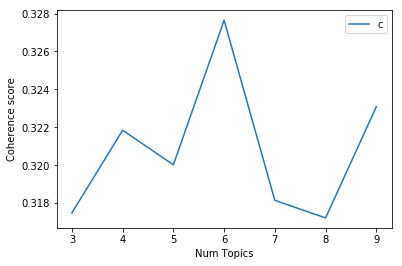

In [10]:
# Show graph
limit = 10
start = 3
step = 1
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [11]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 3  has Coherence Value of 0.3175
Num Topics = 4  has Coherence Value of 0.3218
Num Topics = 5  has Coherence Value of 0.32
Num Topics = 6  has Coherence Value of 0.3276
Num Topics = 7  has Coherence Value of 0.3181
Num Topics = 8  has Coherence Value of 0.3172
Num Topics = 9  has Coherence Value of 0.3231


In [12]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.052*"information" + 0.017*"service" + 0.016*"site" + 0.015*"personal" + '
  '0.012*"party" + 0.011*"website" + 0.009*"third" + 0.008*"provide" + '
  '0.008*"email" + 0.007*"user"'),
 (1,
  '0.044*"information" + 0.017*"site" + 0.012*"email" + 0.011*"service" + '
  '0.009*"website" + 0.009*"third" + 0.009*"personal" + 0.008*"address" + '
  '0.007*"collect" + 0.007*"party"'),
 (2,
  '0.060*"information" + 0.018*"site" + 0.016*"service" + 0.011*"user" + '
  '0.010*"website" + 0.010*"personal" + 0.009*"party" + 0.009*"cooky" + '
  '0.008*"collect" + 0.008*"address"'),
 (3,
  '0.063*"information" + 0.018*"site" + 0.015*"service" + 0.010*"party" + '
  '0.009*"third" + 0.009*"personal" + 0.009*"provide" + 0.009*"user" + '
  '0.008*"collect" + 0.008*"website"'),
 (4,
  '0.047*"information" + 0.016*"site" + 0.014*"service" + 0.012*"email" + '
  '0.009*"personal" + 0.008*"address" + 0.008*"provide" + 0.007*"third" + '
  '0.007*"cooky" + 0.007*"user"'),
 (5,
  '0.036*"information" + 0.0

In [16]:
# Save model to disk.
temp_file = datapath("./optimal_LDA_model")
optimal_model.save(temp_file)

# Load a potentially pretrained model from disk.
# lda = LdaModel.load(temp_file)


In [14]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis

/anaconda3/envs/insight_s19/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.003743  0.003617       1        1  33.319550
0     -0.007952 -0.005445       2        1  27.135845
3     -0.002603  0.005901       3        1  19.043497
4      0.004291 -0.003787       4        1   9.309510
1      0.006109  0.001341       5        1   5.673328
5      0.003899 -0.001627       6        1   5.518272, topic_info=    Category          Freq          Term         Total  loglift  logprob
366  Default  15596.000000   information  15596.000000  30.0000  30.0000
679  Default   4961.000000          site   4961.000000  29.0000  29.0000
250  Default   2464.000000         email   2464.000000  28.0000  28.0000
668  Default   4417.000000       service   4417.000000  27.0000  27.0000
744  Default   2462.000000         third   2462.000000  26.0000  26.0000
807  Default   2707.000000       website   2707.000000  25.0000  25.0000
170  Default   2129.000000         cooky   2129.000000  24.0000  24.0000
19   Default   2020.000000       address   2020.000000  23.0000  23.0000
507  Default   2742.000000         party   2742.000000  22.0000  22.0000
515  Default   3105.000000      personal   3105.000000  21.0000  21.0000
45   Default   1502.000000          also   1502.000000  20.0000  20.0000
778  Default   2478.000000          user   2478.000000  19.0000  19.0000
187  Default   1357.000000          data   1357.000000  18.0000  18.0000
3    Default   1520.000000        access   1520.000000  17.0000  17.0000
745  Default   1570.000000          time   1570.000000  16.0000  16.0000
563  Default   2311.000000       provide   2311.000000  15.0000  15.0000
127  Default   2134.000000       collect   2134.000000  14.0000  14.0000
969  Default   1083.000000    personally   1083.000000  13.0000  13.0000
551  Default   1174.000000       product   1174.000000  12.0000  12.0000
157  Default   1299.000000       contact   1299.000000  11.0000  11.0000
927  Default   1095.000000  identifiable   1095.000000  10.0000  10.0000
160  Default   1345.000000       content   1345.000000   9.0000   9.0000
571  Default   1096.000000       purpose   1096.000000   8.0000   8.0000
30   Default   1234.000000   advertising   1234.000000   7.0000   7.0000
617  Default   1142.000000       request   1142.000000   6.0000   6.0000
479  Default   1457.000000        online   1457.000000   5.0000   5.0000
498  Default   1001.000000          page   1001.000000   4.0000   4.0000
642  Default    931.000000         right    931.000000   3.0000   3.0000
459  Default    954.000000          name    954.000000   2.0000   2.0000
6    Default   1497.000000       account   1497.000000   1.0000   1.0000
..       ...           ...           ...           ...      ...      ...
969   Topic6     75.832329    personally   1083.633911   0.2376  -5.3325
668   Topic6    243.610001       service   4417.238281  -0.0006  -4.1654
445   Topic6     46.382191       message    614.235352   0.3136  -5.8241
507   Topic6    158.940155         party   2742.638428   0.0490  -4.5925
927   Topic6     73.478317  identifiable   1095.445923   0.1952  -5.3640
759   Topic6     40.306110          type    533.776306   0.3136  -5.9645
778   Topic6    140.053146          user   2478.472412   0.0237  -4.7190
744   Topic6    138.813980         third   2462.746582   0.0212  -4.7279
807   Topic6    148.666946       website   2707.196777  -0.0049  -4.6593
30    Topic6     78.481750   advertising   1234.842773   0.1413  -5.2981
745   Topic6     93.700897          time   1570.902954   0.0778  -5.1209
366   Topic6    558.266724   information  15596.091797  -0.4328  -3.3362
498   Topic6     65.161743          page   1001.352661   0.1649  -5.4841
781   Topic6     56.722778         using    844.814575   0.1962  -5.6228
157   Topic6     77.233208       contact   1299.567017   0.0741  -5.3142
19    Topic6    106.368706       address   2020.443359  -0.0471  -4.9941
45    Topic6     85.6

In [15]:
pyLDAvis.save_html(vis, 'pp_pylda_vis.html')

In [17]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis_tsne = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word, mds = 'tsne')
vis_tsne

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
2      15.046137   7.186164       1        1  33.274483
0       9.724442  13.850856       2        1  27.102100
3       1.905665   2.359922       3        1  19.214546
4       1.679781  11.019171       4        1   9.172740
1       7.714116   6.943252       5        1   5.801170
5      10.264927   0.010398       6        1   5.434951, topic_info=    Category          Freq          Term         Total  loglift  logprob
366  Default  15602.000000   information  15602.000000  30.0000  30.0000
679  Default   4961.000000          site   4961.000000  29.0000  29.0000
250  Default   2462.000000         email   2462.000000  28.0000  28.0000
668  Default   4415.000000       service   4415.000000  27.0000  27.0000
744  Default   2463.000000         third   2463.000000  26.0000  26.0000
807  Default   2707.000000       website   2707.000000  25.0000  25.0000
170  Default   2128.000000         cooky   2128.000000  24.0000  24.0000
19   Default   2020.000000       address   2020.000000  23.0000  23.0000
507  Default   2742.000000         party   2742.000000  22.0000  22.0000
515  Default   3105.000000      personal   3105.000000  21.0000  21.0000
778  Default   2478.000000          user   2478.000000  20.0000  20.0000
45   Default   1502.000000          also   1502.000000  19.0000  19.0000
187  Default   1357.000000          data   1357.000000  18.0000  18.0000
3    Default   1520.000000        access   1520.000000  17.0000  17.0000
745  Default   1571.000000          time   1571.000000  16.0000  16.0000
563  Default   2311.000000       provide   2311.000000  15.0000  15.0000
127  Default   2135.000000       collect   2135.000000  14.0000  14.0000
969  Default   1084.000000    personally   1084.000000  13.0000  13.0000
551  Default   1173.000000       product   1173.000000  12.0000  12.0000
157  Default   1298.000000       contact   1298.000000  11.0000  11.0000
927  Default   1096.000000  identifiable   1096.000000  10.0000  10.0000
160  Default   1345.000000       content   1345.000000   9.0000   9.0000
571  Default   1095.000000       purpose   1095.000000   8.0000   8.0000
30   Default   1233.000000   advertising   1233.000000   7.0000   7.0000
617  Default   1142.000000       request   1142.000000   6.0000   6.0000
479  Default   1456.000000        online   1456.000000   5.0000   5.0000
498  Default   1000.000000          page   1000.000000   4.0000   4.0000
642  Default    932.000000         right    932.000000   3.0000   3.0000
459  Default    954.000000          name    954.000000   2.0000   2.0000
6    Default   1496.000000       account   1496.000000   1.0000   1.0000
..       ...           ...           ...           ...      ...      ...
969   Topic6     74.687340    personally   1084.169556   0.2371  -5.3325
668   Topic6    239.931747       service   4415.570801  -0.0002  -4.1654
445   Topic6     45.681866       message    613.859985   0.3143  -5.8241
507   Topic6    156.540329         party   2742.952148   0.0488  -4.5925
927   Topic6     72.368874  identifiable   1096.233643   0.1945  -5.3640
759   Topic6     39.697529          type    533.092163   0.3149  -5.9645
778   Topic6    137.938477          user   2478.187012   0.0238  -4.7190
744   Topic6    136.718033         third   2463.687256   0.0208  -4.7279
807   Topic6    146.422226       website   2707.598145  -0.0050  -4.6593
30    Topic6     77.296753   advertising   1233.534912   0.1423  -5.2981
745   Topic6     92.286110          time   1571.523071   0.0774  -5.1209
366   Topic6    549.837463   information  15602.939453  -0.4333  -3.3362
498   Topic6     64.177864          page   1000.467957   0.1658  -5.4841
781   Topic6     55.866322         using    844.916748   0.1960  -5.6228
157   Topic6     76.067062       contact   1298.752075   0.0748  -5.3142
19    Topic6    104.762650       address   2020.407349  -0.0470  -4.9941
45   

In [49]:
def fit_topic_to_text(text, count_vec = vectorizer, model = model):
    # For user input text, returns which topic best fits the input. 
    tf = count_vec.fit_transform(text)
    return(model.transform(tf))

NameError: name 'vectorizer' is not defined

In [50]:
def display_topics(feature_names, no_top_words, topic_words):
    word_dict = {}
    for topic_idx, topic in enumerate(model.components_):
#         print(topic_idx)
#         print ([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
        word_dict['Topic ' + str(topic_idx)] =[feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(word_dict)#, columns=['Topic ' + str(k) for k in range(len(model.components_))])

In [51]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=split_data_words):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series(
                    [int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic',
                              'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(
    ldamodel=optimal_model, corpus=corpus, texts=split_data_words)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = [
    'Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [52]:
optimal_model.show_topics(formatted=True, num_words=10)

[(0,
  '0.052*"information" + 0.017*"service" + 0.016*"site" + 0.015*"personal" + 0.012*"party" + 0.011*"website" + 0.009*"third" + 0.008*"provide" + 0.008*"email" + 0.007*"user"'),
 (1,
  '0.044*"information" + 0.017*"site" + 0.012*"email" + 0.011*"service" + 0.009*"website" + 0.009*"third" + 0.009*"personal" + 0.008*"address" + 0.007*"collect" + 0.007*"party"'),
 (2,
  '0.060*"information" + 0.018*"site" + 0.016*"service" + 0.011*"user" + 0.010*"website" + 0.010*"personal" + 0.009*"party" + 0.009*"cooky" + 0.008*"collect" + 0.008*"address"'),
 (3,
  '0.063*"information" + 0.018*"site" + 0.015*"service" + 0.010*"party" + 0.009*"third" + 0.009*"personal" + 0.009*"provide" + 0.009*"user" + 0.008*"collect" + 0.008*"website"'),
 (4,
  '0.047*"information" + 0.016*"site" + 0.014*"service" + 0.012*"email" + 0.009*"personal" + 0.008*"address" + 0.008*"provide" + 0.007*"third" + 0.007*"cooky" + 0.007*"user"'),
 (5,
  '0.036*"information" + 0.020*"site" + 0.016*"service" + 0.014*"email" + 0.01

In [53]:
df_dominant_topic.head(2)
# merge topic info with main df
df_with_topic = pd.concat([df, df_dominant_topic], axis = 1)
df_with_topic.head(5)

,doc_type,file,text,year,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,pp,/Users/dbm/Downloads/OPP-115/sanitized_policie...,Privacy Policy Last Modified March 25 2013 Thi...,2013,0,2.0,0.3610,"information, site, service, user, website, per...","[last, modified, march, latinpost, site, inten..."
1,pp,/Users/dbm/Downloads/OPP-115/sanitized_policie...,Welcome to the Google Privacy Policy When you...,2015,1,2.0,0.9922,"information, site, service, user, website, per...","[welcome, google, google, service, trust, info..."
2,pp,/Users/dbm/Downloads/OPP-115/sanitized_policie...,Web Privacy Statement Austin Community Colleg...,,2,3.0,0.9234,"information, site, service, party, third, pers...","[statement, austin, community, college, commit..."
3,pp,/Users/dbm/Downloads/OPP-115/sanitized_policie...,Privacy Policy PBS is committed to protecting ...,2009,3,5.0,0.4420,"information, site, service, email, party, webs...","[committed, protecting, private, information, ..."
4,pp,/Users/dbm/Downloads/OPP-115/sanitized_policie...,Privacy Security and Accessibility Policies US...,,4,2.0,0.7785,"information, site, service, user, website, per...","[security, accessibility, policy, doesnt, coll..."


### Summarize by topic

In [55]:
# Get the top n documents for each topic
tmp = df_with_topic.groupby('Dominant_Topic')

# dfs = []
# # top_n = 3

# for group, _df in tmp:
#     indices = _df['Topic_Perc_Contrib'].sort_values(ascending=False)
#     _df = _df[_df['Topic_Perc_Contrib'].isin(indices[:])].sort_values('Topic_Perc_Contrib', ascending=False)
#     dfs.append(_df)

# dfs = pd.concat(dfs, axis=0)

summary_stories = []

for group, _df in tmp:  
#     display(' '.join(_df['story']))
    summary = summarize(' '.join(_df['text']), ratio = .05, split = True)   
    summary_stories.append({'Dominant Topic':group, 'Summary':summary})


# df_with_topic = dfs.join(df.set_index('Document_No'), on='Document_No')
# df_with_topic.head(5)

KeyboardInterrupt: 

In [ ]:
summary_df = pd.DataFrame(summary_stories).head(2)

## Apply saved model to new data

In [ ]:
# Create a new corpus, made of previously unseen documents.


other_corpus = [common_dictionary.doc2bow(text) for text in new_pp]

unseen_doc = other_corpus[0]
vector = lda[unseen_doc]  # get topic probability distribution for a document
Update the model by incrementally training on the new corpus

optimal_model.update(other_corpus)
vector = lda[unseen_doc]

## References
- https://nbviewer.jupyter.org/github/bmabey/hacker_news_topic_modelling/blob/master/HN%20Topic%20Model%20Talk.ipynb